In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from util import test_loss_Unet, train_U_NET, plot_loss, plot_acc, inference_time

plt.rcParams['figure.dpi'] = 100

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 4
image_size = (256, 256)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(image_size)])

target_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.007843137718737125, 0.003921568393707275),transforms.CenterCrop(image_size), 
    transforms.Normalize(-1, 1)])

train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="trainval", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="test", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

input_shape = (batch_size, 3, image_size[0], image_size[1])

In [4]:
uniq = []
for img in train_dataset:
    uniq.extend(torch.unique(img[1]).numpy())
    uniq = np.unique(uniq).tolist()
    break
#uniq = np.array(uniq).astype(int)
print(uniq)

[-1.1920928955078125e-07, 1.0, 2.0]


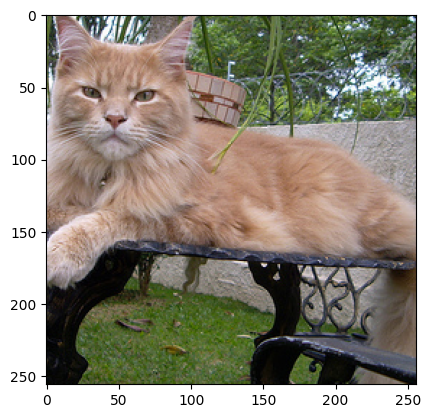

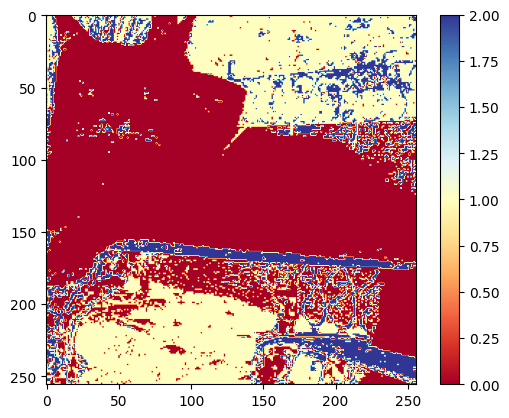

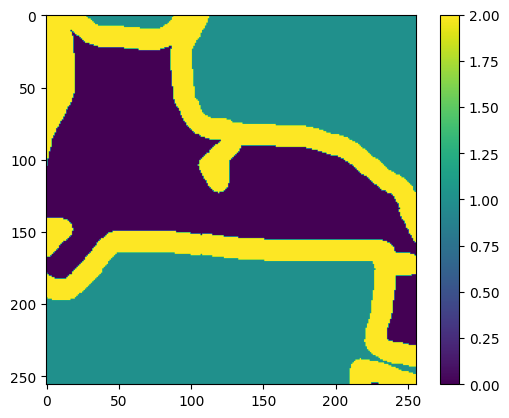

tensor(-1.1921e-07)


In [5]:
#print(train_dataset[2][0].shape)
img = torch.transpose(train_dataset[1000][0], 2,0)
img = torch.transpose(img, 1,0)
plt.imshow(img)
plt.show()

img_max = torch.argmax(train_dataset[1000][0], 0)
#img_max = torch.transpose(img_max, 2,0)
#img_max = torch.argmax(img_max, 2)
plt.imshow(img_max, cmap="RdYlBu")
plt.colorbar()
plt.show()

seg = torch.transpose(train_dataset[1000][1], 2,0)
seg = torch.transpose(seg, 1,0)
plt.imshow(seg)
plt.colorbar()
plt.show()
print(torch.min(seg))

In [4]:
from Models import U_Net

U_NN = U_Net(input_shape, output_channels=3, initial_lr=0.01, momentum=0.9, weight_decay=0)

summary(U_NN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
U_Net                                    [4, 3, 256, 256]          --
├─ModuleDict: 1-1                        --                        --
│    └─Sequential: 2-1                   [4, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [4, 64, 256, 256]         1,792
│    │    └─ReLU: 3-2                    [4, 64, 256, 256]         --
│    │    └─BatchNorm2d: 3-3             [4, 64, 256, 256]         128
│    │    └─Conv2d: 3-4                  [4, 64, 256, 256]         36,928
│    │    └─ReLU: 3-5                    [4, 64, 256, 256]         --
│    │    └─BatchNorm2d: 3-6             [4, 64, 256, 256]         128
│    └─MaxPool2d: 2-2                    [4, 64, 128, 128]         --
│    └─Sequential: 2-3                   [4, 128, 128, 128]        --
│    │    └─Conv2d: 3-7                  [4, 128, 128, 128]        73,856
│    │    └─ReLU: 3-8                    [4, 128, 128, 128]        --
│ 

In [4]:
PATH = "./models/U_Net/U_NN.pth"

if exists(PATH):
    U_NN = torch.load(PATH)
    U_NN.eval()

In [5]:
criterion = CrossEntropyLoss()
epochs = 5

train_U_NET(U_NN, criterion=criterion, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
        epochs=epochs, batches_to_test=300, patience=5, device=device, print_test=True, verbose=False, p_randomTransform=0.6)

[1,   300] train_loss: 0.213
test_loss: 0.380, test_accuracy: 86.05559321247807
[1,   600] train_loss: 0.229
test_loss: 0.392, test_accuracy: 85.80369260532714
[1,   900] train_loss: 0.236
test_loss: 0.408, test_accuracy: 84.80915517695237
[2,   280] train_loss: 0.212
test_loss: 0.387, test_accuracy: 86.09895745165896
[2,   580] train_loss: 0.241
test_loss: 0.363, test_accuracy: 86.43773251250447
[2,   880] train_loss: 0.220
test_loss: 0.383, test_accuracy: 86.29750511437679
[3,   260] train_loss: 0.209
test_loss: 0.380, test_accuracy: 86.59262107418681
[3,   560] train_loss: 0.208
test_loss: 0.396, test_accuracy: 85.60137370523623
[3,   860] train_loss: 0.213
test_loss: 0.416, test_accuracy: 85.4015605070832
[4,   240] train_loss: 0.203
test_loss: 0.370, test_accuracy: 86.45456334361266
[4,   540] train_loss: 0.205
test_loss: 0.386, test_accuracy: 86.15619433806683
[4,   840] train_loss: 0.205
test_loss: 0.377, test_accuracy: 86.4686867689755
[5,   220] train_loss: 0.199
test_loss: 0.

In [6]:
torch.save(U_NN, "./models/U_Net/U_NN.pth")

In [7]:
U_NN = torch.load("./models/U_Net/U_NN.pth")

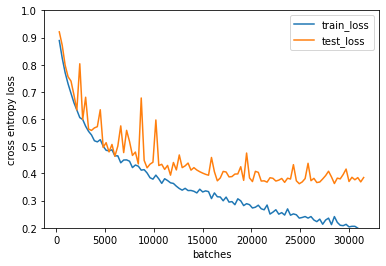

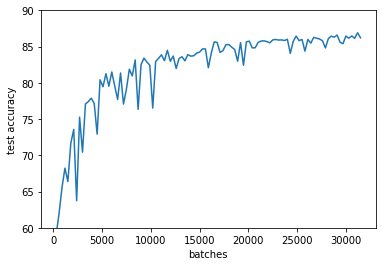

In [8]:
plot_loss(U_NN, y_lim=(0.2, 1))
plot_acc(U_NN, y_lim=(60, 90))

In [6]:
print("Training time (s):")
print(f"mean: {round(np.mean(U_NN.train_time), 3)}")
print(f"std: {round(np.std(U_NN.train_time), 3)}")

Training time (s):
mean: 124.439
std: 5.22


In [13]:
inference_times = inference_time(U_NN, input_shape=(1, 3, 32, 32), repetitions=1000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
5.002e+00
1.8e-01


In [7]:
inference_times = inference_time(U_NN, input_shape=(1, 3, 32, 32), repetitions=1000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
9.890e+00
2.0e+00


In [8]:
inference_times = inference_time(U_NN, input_shape=(10, 3, 32, 32), repetitions=1000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
2.222e+01
1.0e-01


In [9]:
inference_times = inference_time(U_NN, input_shape=(10, 3, 32, 32), repetitions=1000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
5.340e+01
9.3e+00


In [10]:
inference_times = inference_time(U_NN, input_shape=(50, 3, 32, 32), repetitions=1000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
1.076e+02
2.0e-01


In [11]:
inference_times = inference_time(U_NN, input_shape=(50, 3, 32, 32), repetitions=1000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
2.894e+02
3.5e+01


846


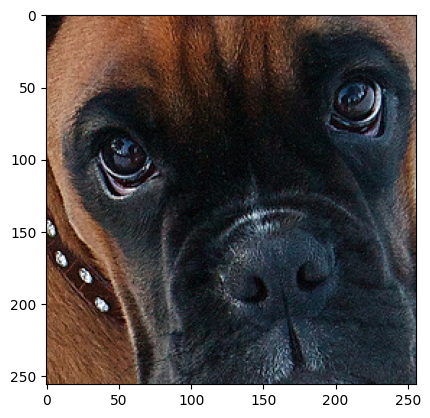

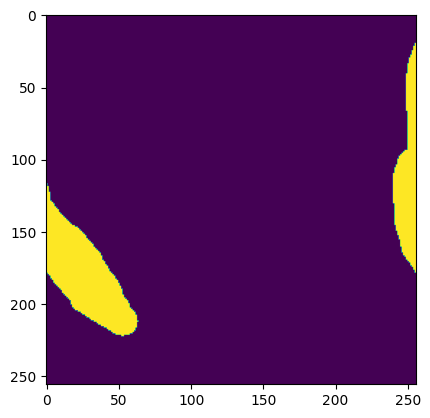

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [12]:
def show_segmentation_results(NN, dataset, index, device):
    img = torch.transpose(dataset[index][0], 2, 0)
    img = torch.transpose(img, 1,0)
    plt.imshow(img)
    plt.show()

    plt.imshow(dataset[index][1][0])
    plt.show()

    seg = dataset[index][0]
    seg = seg[None,:,:,:].to(device)
    outputs = NN(seg)
    outputs = torch.argmax(outputs, 1, keepdim=True)
    plt.imshow(outputs[0][0].detach().to("cpu").numpy())
    plt.show()

ind = int(np.random.rand(1) * 1000)
print(ind)
show_segmentation_results(U_NN, test_dataset, ind, device)

In [5]:
U_NN = torch.load("./models/U_Net/U_NN.pth")

In [6]:
U_NN_ASL = torch.load("./models/U_Net/U_NN_ASL.pth")

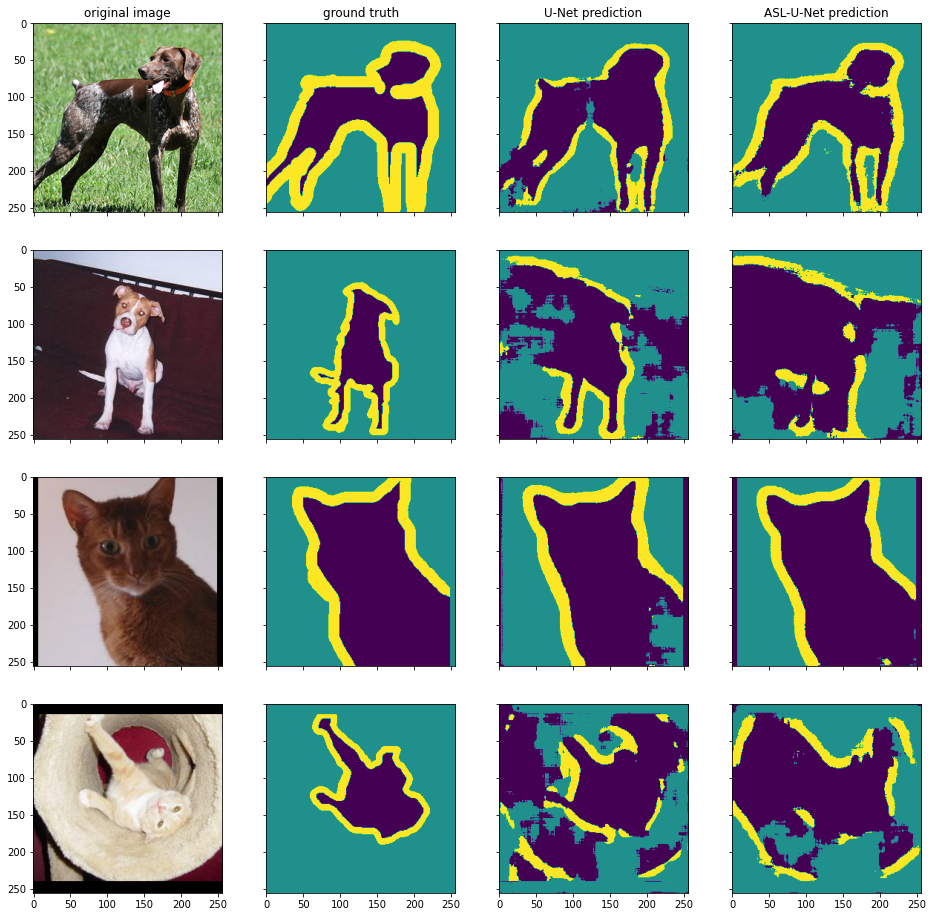

In [7]:
def show_segmentation_results(NN, NN_ASL, dataset, index, device):
    rows = index.shape[0]
    columns = 4
    size = (16, 16)
    fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

    for row in range(rows):
        img = torch.transpose(dataset[index[row]][0], 2, 0)
        img = torch.transpose(img, 1,0)
        ax[row, 0].imshow(img)

        ax[row, 1].imshow(dataset[index[row]][1][0])

        seg = dataset[index[row]][0]
        seg = seg[None,:,:,:].to(device)
        outputs = NN(seg)
        outputs = torch.argmax(outputs, 1, keepdim=True)
        ax[row, 2].imshow(outputs[0][0].detach().to("cpu").numpy())

        seg = dataset[index[row]][0]
        seg = seg[None,:,:,:].to(device)
        outputs = NN_ASL(seg)
        outputs = torch.argmax(outputs, 1, keepdim=True)
        ax[row, 3].imshow(outputs[0][0].detach().to("cpu").numpy())

    ax[0, 0].set_title("original image")
    ax[0, 1].set_title("ground truth")
    ax[0, 2].set_title("U-Net prediction")
    ax[0, 3].set_title("ASL-U-Net prediction")
    plt.show()

# ind = int(np.random.rand(1) * 1000)
# print(ind)
# best image 15
#ind = np.array([123, 203, 162, 202, 4, 7, 15, 20])
ind = np.arange(4) + 1476
ind = np.array([162, 202, 1402, 1302, 1440, 1448, 1455])
ind = np.array([1414, 202, 7, 20])
show_segmentation_results(U_NN, U_NN_ASL, test_dataset, ind, device)